In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [62]:
# Cargamos el dataset descargado de la colección de datos (output de 01_data_collection)
file_path = 'data/BTC_5m_ohlcv.csv'
df = pd.read_csv(file_path)

# Vista previa para verificar
df.head()

,timestamp,open,high,low,close,volume
0,2024-01-01 06:00:00,42234.01,42277.30,42208.68,42277.29,69.10295
1,2024-01-01 06:05:00,42277.30,42301.98,42275.00,42290.19,72.05076
2,2024-01-01 06:10:00,42290.19,42290.19,42262.00,42276.01,50.05483
3,2024-01-01 06:15:00,42276.00,42344.76,42270.22,42342.01,50.25578
4,2024-01-01 06:20:00,42342.01,42342.01,42281.10,42311.16,37.33549


In [64]:
# Revisamos las columnas disponibles
print("Columnas actuales:", df.columns.tolist())

# Verificamos si existen valores nulos en las columnas básicas
print("Valores nulos por columna:")
print(df.isnull().sum())


Columnas actuales: ['timestamp', 'open', 'high', 'low', 'close', 'volume']
Valores nulos por columna:
timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64


In [66]:
# Eliminamos duplicados si existen
df.drop_duplicates(inplace=True)

# Eliminamos filas con valores nulos en columnas clave
df.dropna(subset=['timestamp', 'open', 'high', 'low', 'close', 'volume'], inplace=True)

# Convertimos timestamp a datetime si no se ha hecho
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Revisamos que el volumen no tenga valores negativos o cero (pueden ser errores)
df = df[df['volume'] > 0]

# Confirmamos la limpieza
print(f"Dataset limpio. Total de registros: {len(df)}")


Dataset limpio. Total de registros: 128120


In [68]:
# Retorno logarítmico
df['log_return'] = np.log(df['close'] / df['close'].shift(1))

# Cambio porcentual
df['pct_change'] = df['close'].pct_change()

# Rellenar posibles nulos iniciales
df.fillna(0, inplace=True)


In [70]:
# Revisamos si las bandas de Bollinger existen y calculamos bb_width
if 'bb_upper' not in df.columns or 'bb_lower' not in df.columns:
    # Si no existen, calculamos las bandas de Bollinger básicas
    window = 20
    df['sma_20'] = df['close'].rolling(window=window).mean()
    df['stddev_20'] = df['close'].rolling(window=window).std()

    df['bb_upper'] = df['sma_20'] + (df['stddev_20'] * 2)
    df['bb_lower'] = df['sma_20'] - (df['stddev_20'] * 2)

# Ahora calculamos bb_width
if 'bb_width' not in df.columns:
    df['bb_width'] = df['bb_upper'] - df['bb_lower']

# Eliminamos valores nulos generados por rolling windows
df.dropna(inplace=True)

# Confirmamos las nuevas columnas
print("Columnas tras agregar bandas de Bollinger y bb_width:")
print(df.columns.tolist())


Columnas tras agregar bandas de Bollinger y bb_width:
['timestamp', 'open', 'high', 'low', 'close', 'volume', 'log_return', 'pct_change', 'sma_20', 'stddev_20', 'bb_upper', 'bb_lower', 'bb_width']


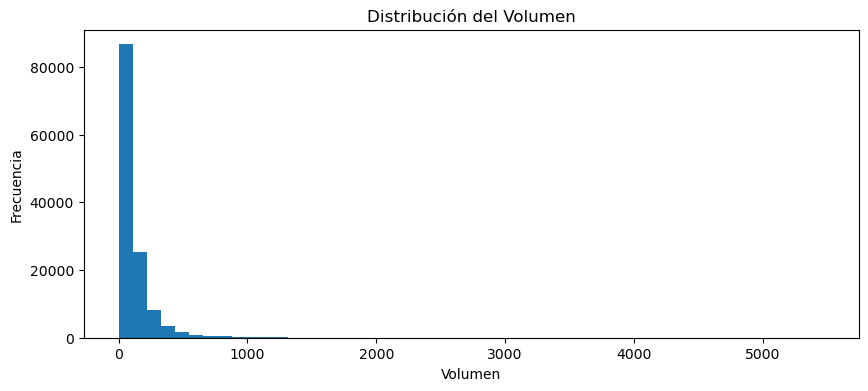

Datos filtrados de volumen extremo. Total de registros: 126820


In [72]:
# Analizamos el volumen para detectar valores atípicos
plt.figure(figsize=(10, 4))
plt.hist(df['volume'], bins=50)
plt.title('Distribución del Volumen')
plt.xlabel('Volumen')
plt.ylabel('Frecuencia')
plt.show()

# Opcional: podemos eliminar outliers extremos
percentile_99 = df['volume'].quantile(0.99)
df = df[df['volume'] <= percentile_99]

print(f"Datos filtrados de volumen extremo. Total de registros: {len(df)}")


In [74]:
# Guardamos el dataset listo para feature engineering o modelado
output_file = 'data/BTC_5m_preprocessed.csv'
df.to_csv(output_file, index=False)

print(f"✅ Dataset preprocesado guardado en {output_file}")
df.tail()


✅ Dataset preprocesado guardado en data/BTC_5m_preprocessed.csv


,timestamp,open,high,low,close,volume,log_return,pct_change,sma_20,stddev_20,bb_upper,bb_lower,bb_width
128115,2025-03-21 02:15:00,84653.06,84653.06,84566.39,84574.53,32.83500,-0.000928,-0.000928,84575.3220,112.292863,84799.907727,84350.736273,449.171454
128116,2025-03-21 02:20:00,84574.53,84579.32,84520.67,84547.56,16.44097,-0.000319,-0.000319,84580.9605,107.598104,84796.156708,84365.764292,430.392417
128117,2025-03-21 02:25:00,84547.57,84666.61,84547.56,84630.43,69.40393,0.000980,0.000980,84587.4830,106.377733,84800.238465,84374.727535,425.510931
128118,2025-03-21 02:30:00,84630.44,84644.00,84572.54,84580.06,26.96325,-0.000595,-0.000595,84589.7335,105.683939,84801.101378,84378.365622,422.735756
128119,2025-03-21 02:35:00,84580.06,84629.99,84580.06,84601.62,7.09480,0.000255,0.000255,84594.4610,103.891100,84802.243201,84386.678799,415.564402
